Extract data from a DAO NetCDF file

In [1]:
import numpy as np
import xarray as xr

In [2]:
#ds = xr.open_dataset("dao.80_93.nc")
ds = xr.open_dataset("/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/3_ESA_GRANT/MODEL/data/dao.80_93.nc")

In [3]:
if ds.coords["level"].isnull().all():
    print("Fixing broken pressure level data")
    levels = [1000.0, 950.0, 900.0, 850.0, 700.0, 500.0, 300.0, 200.0]
    ds.coords["level"] = xr.DataArray(levels, dims=["level"], coords={"level": levels}, attrs={"units": "hPa"})

Fixing broken pressure level data


In [4]:
# make sure lat runs from south to north
if not ds["lat"].to_index().is_monotonic_increasing:
    print("flipping lat")
    ds = ds.sortby("lat", ascending=True)

flipping lat


In [5]:
# make sure lon runs from west to east
if not ds["lon"].to_index().is_monotonic_increasing:
    print("flipping lon")
    ds = ds.sortby("lon", ascending=True)

In [6]:
# get a spatial subset 4°N–16°S, 50°–76°W
ds = ds.sel(lat=slice(-16, 4), lon=slice(-76, -50))

In [7]:
# make sure that the order of the dimensions is (lon, lat, ...) for all variables
ds = ds.transpose("lon", "lat", ...)

In [8]:
# grab the first time step
# should be Jan 1980
ds = ds.isel(time=0, drop=True)

To integrate the column water vapor fluxes this notebook uses a basic method `integrate_no_extrapolation`.

See below for a comparison between the DAO dataset precipitation (which is not used in the bulk recycling model) and modelled precipitation.

An alternative method is `integrate_with_extrapolation`,
which has been shown to produce modelled precipitation that has a slightly better agreement to the DAO dataset than `integrate_no_extrapolation`.
The difference is small (~0.2 mm/day) compared to the RMSE of ~4.5 mm/day.

If measurements of surface-level specific humidity and wind speeds are available, the method `integrate_with_surface_value` may offer an improvement.

In [9]:
import bulk_recycling_model.numerical_integration

In [10]:
# Integrate 10^-3 Shum Uwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Uwnd"]
Fx = bulk_recycling_model.numerical_integration.integrate_no_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

In [11]:
# Integrate 10^-3 Shum Vwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Vwnd"]
Fy = bulk_recycling_model.numerical_integration.integrate_no_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

some plots directly from xarray

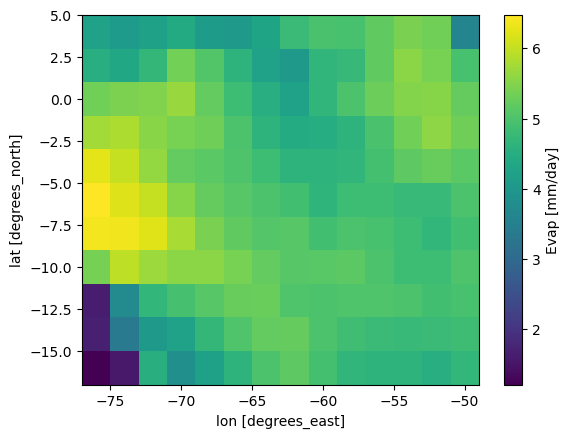

In [12]:
ds["Evap"].plot.pcolormesh(x="lon", y="lat")

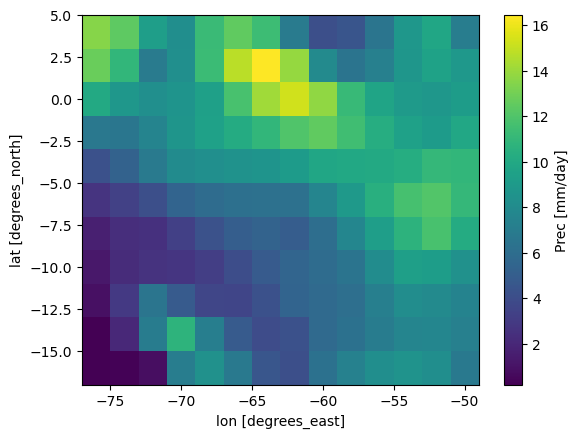

In [13]:
ds["Prec"].plot.pcolormesh(x="lon", y="lat")

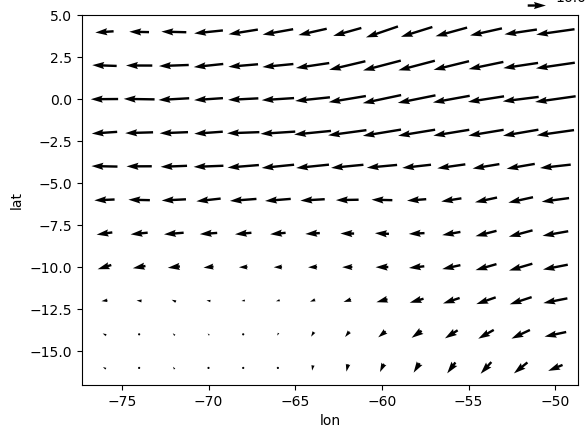

In [14]:
xr.Dataset(
    {
        "Fx": Fx,
        "Fy": Fy,
    },
).plot.quiver(
    x="lon",
    y="lat",
    u="Fx",
    v="Fy",
)

Prepare and scale the data

In [15]:
from bulk_recycling_model import preprocess
from bulk_recycling_model.axis import Axis
from bulk_recycling_model.scaling import Scaling, UnitSystem

In [16]:
# degrees
L = ds.coords["lon"].max().item() - ds.coords["lon"].min().item()
# convert to meters
L = L * 111e3 * np.cos(np.deg2rad(ds.coords["lat"].mean().item()))
dx = L / ds.sizes["lon"]

In [17]:
# lon axis
lon_axis = Axis(
    ds.coords["lon"].min().item(),
    ds.coords["lon"].diff("lon").mean().item(),
    ds.sizes["lon"],
)

In [18]:
# degrees
H = ds.coords["lat"].values[-1] - ds.coords["lat"].values[0]
# convert to meters
H = H * 111e3
dy = H / ds.sizes["lat"]

In [19]:
# lat axis
lat_axis = Axis(
    ds.coords["lat"].min().item(),
    ds.coords["lat"].diff("lat").mean().item(),
    ds.sizes["lat"],
)

In [20]:
print(f"{L = :.2e} m")
print(f"{dx = :.2e} m")
print(f"{H = :.2e} m")
print(f"{dy = :.2e} m")


L = 2.87e+06 m
dx = 2.05e+05 m
H = 2.22e+06 m
dy = 2.02e+05 m


In [21]:
# make a scaling object to convert between unit systems
scaling = Scaling(H)

In [22]:
dx = scaling.distance.convert(dx, UnitSystem.SI, UnitSystem.scaled)
dy = scaling.distance.convert(dy, UnitSystem.SI, UnitSystem.scaled)
print(f"{dx = :.2e} scaled")
print(f"{dy = :.2e} scaled")

dx = 9.23e-02 scaled
dy = 9.09e-02 scaled


In [23]:
# convert Fx and Fy to scaled units
Fx = scaling.water_vapor_flux.convert(Fx.values, UnitSystem.natural, UnitSystem.scaled)
Fy = scaling.water_vapor_flux.convert(Fy.values, UnitSystem.natural, UnitSystem.scaled)

In [24]:
# preprocess water vapor fluxes onto the secondary grid
Fx_left = preprocess.prepare_Fx_left(Fx)
Fx_right = preprocess.prepare_Fx_right(Fx)
Fy_bottom = preprocess.prepare_Fy_bottom(Fy)
Fy_top = preprocess.prepare_Fy_top(Fy)

In [25]:
# convert E to scaled units
E = scaling.evaporation.convert(ds["Evap"].values, UnitSystem.natural, UnitSystem.scaled)

In [26]:
# preprocess E onto the secondary grid
E = preprocess.prepare_E(E)

In [27]:
# compute P
P = preprocess.calculate_precipitation(Fx_left, Fx_right, Fy_bottom, Fy_top, E, dx, dy)

plotting

In [28]:
import matplotlib.pyplot as plt

In [29]:
from bulk_recycling_model import plotting

Text(0.5, 0.98, 'Evaporation on the secondary grid')

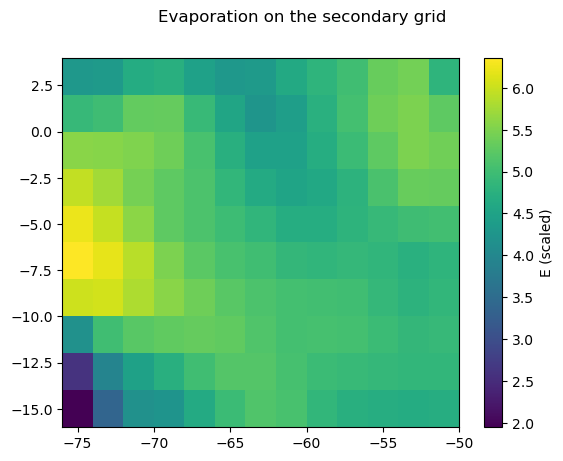

In [30]:
fig, ax = plt.subplots()
collection = plotting.pcolormesh(ax, E, lon_axis, lat_axis)
fig.colorbar(collection, label="E (scaled)")
fig.suptitle("Evaporation on the secondary grid")

Text(0.5, 0.98, 'Calculated Precipitation')

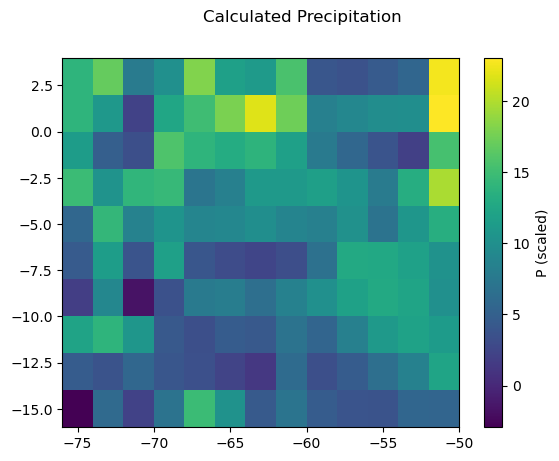

In [31]:
fig, ax = plt.subplots()
collection = plotting.pcolormesh(ax, P, lon_axis, lat_axis)
fig.colorbar(collection, label="P (scaled)")
fig.suptitle("Calculated Precipitation")

In [32]:
# get modelled P on the secondary grid
modelled_P = preprocess.prepare_P(ds["Prec"].values)
# convert modelled P to scaled units
modelled_P = scaling.precipitation.convert(modelled_P, UnitSystem.natural, UnitSystem.scaled)

In [33]:
print(f"Modelled P has mean {modelled_P.mean()} and std {modelled_P.std()}")
print(f"Calculated P has mean {P.mean()} and std {P.std()}")
print(f"Comparing modelled and calculated precipitation RMSE: {np.sqrt(np.mean((P - modelled_P) ** 2))}")

Modelled P has mean 7.654664039611816 and std 2.954904079437256
Calculated P has mean 8.930608381115261 and std 4.8512904491371085
Comparing modelled and calculated precipitation RMSE: 4.17768849678959


Text(0.5, 0.98, 'Difference between modelled and calculated precipitation')

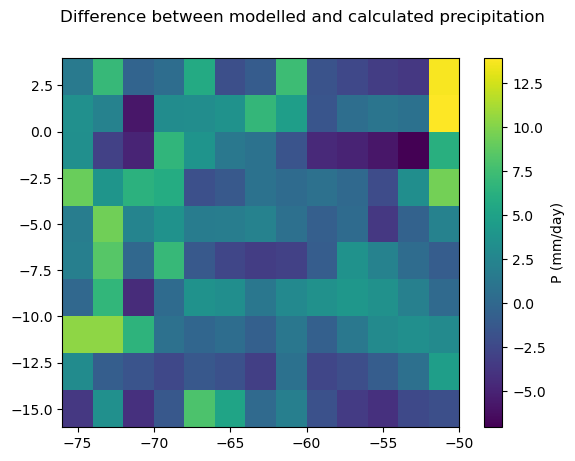

In [34]:
# difference between modelled and calculated precipitation
fig, ax = plt.subplots()
collection = plotting.pcolormesh(ax, P - modelled_P, lon_axis, lat_axis)
fig.colorbar(collection, label="P (mm/day)")
fig.suptitle("Difference between modelled and calculated precipitation")

Text(0.5, 0.98, 'Evaporation + Water Vapor Fluxes on cell edges')

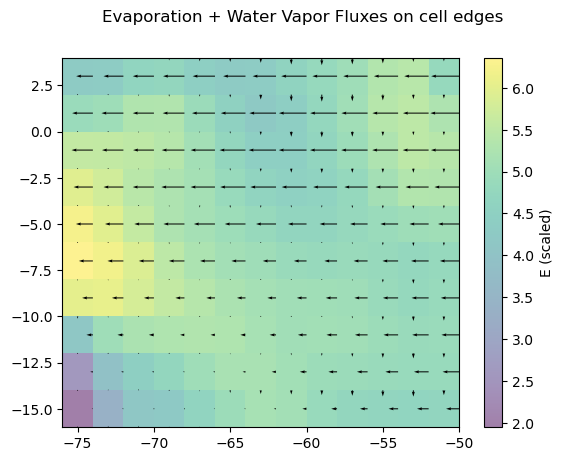

In [35]:
# Create a quiver plot
fig, ax = plt.subplots()
collection = plotting.pcolormesh(ax, E, lon_axis, lat_axis, alpha=0.5)
fig.colorbar(collection, label="E (scaled)")
plotting.quiver(ax, Fx_left, Fx_right, Fy_bottom, Fy_top, lon_axis, lat_axis)
fig.suptitle("Evaporation + Water Vapor Fluxes on cell edges")